# Analyse correlations in alignment of reads to human and arabidopsis

This notebook performs an analysis of a pair of full BAM files, one aligned to human genome and one to Arabidopsis.

It is looking for insert size correlations, specifically the nature of small inserts.

See also the subproject `small-fragments` for a detailed look at the read structure of small fragments.

* Run the bash script before using this notebook.

## Supporting code

In [1]:
import pysam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Code from "small fragments" -- do we need it here?

In [2]:
def get_read_pairs(bam, want_n_pairs, print_qname=False):
    reads = []
    for count, r in enumerate( bam.fetch()):
        if not r.is_read1 or r.mapping_quality < 20 or not r.is_proper_pair:
            continue
        try:
            m8 = bam.mate(r)
        except ValueError:
            continue
        if m8.mapping_quality < 20 or abs(m8.reference_start - r.reference_start) > 3000:
            continue
        if print_qname:
            print("\n", r.query_name)
        reads.append((r, m8))
        if len(reads) == want_n_pairs:
            break
    return reads

In [17]:
sample = "NEB-100ng-1"
tags = ['arabidopsis', 'human']

In [18]:
def next_valid_read(it):
    for r in it:
        if r.is_read1 and r.is_proper_pair and r.mapping_quality >= 20 and not r.is_secondary:
            return r
    return None

In [73]:
bams = [pysam.AlignmentFile(f"data/{sample}-{tag}-qsort.bam") for tag in tags]
iters = [bam.fetch(until_eof=True) for bam in bams]
current_read = [None, next_valid_read(iters[1])]

# The list position acts as an index into arrays iters, current_read, etc.
# It allows to swap around the files and all corresponding values.

# Index into the other arrays: Determines which file is ahead in terms of query
# names, and which one is behind.
behind_file = 0
ahead_file = 1
# All other arrays stay fixed and are referenced through the position array.

MAX_LEN = 1000
size_corr = np.zeros((MAX_LEN, MAX_LEN))
unique = [0, 0]
both = 0

SMALL_FRAG_THRESH = 35
unique_small = [0, 0]
mapped_both_and_small = [0, 0]

counter = 0

while current_read[1]:
    current_read[behind_file] = next_valid_read(iters[behind_file])
    if not current_read[behind_file]:
        break
    elif current_read[behind_file].query_name > current_read[ahead_file].query_name:
        # We found a greater one in the current iterator (which was behind before).
        # Mark the read with qname less, in the "ahead" file, as unique to that file.
        unique[ahead_file] += 1
        if abs(current_read[ahead_file].tlen) < SMALL_FRAG_THRESH:
            unique_small[ahead_file] += 1
        # Then swap the order.
        ahead_file, behind_file = behind_file, ahead_file
    elif current_read[0].query_name == current_read[1].query_name:
        tlens = [min(999, abs(current_read[i].tlen)) for i in (0,1)]
        size_corr[tlens[0], tlens[1]] += 1
        size_corr[tlens[1], tlens[0]] += 1
        both += 1
        for i, t in zip([0,1], tlens):
            if t < SMALL_FRAG_THRESH:
                mapped_both_and_small[i] += 1
        current_read[ahead_file] = next_valid_read(iters[ahead_file])
    else:
        # Our current iterator is still behind. The read we just processed was unique to our file.
        unique[behind_file] += 1
        if abs(current_read[behind_file].tlen) < SMALL_FRAG_THRESH:
            unique_small[behind_file] += 1
    counter += 1
    if counter == 5e6:
        print("Processed", counter, "raw reads")
        break

Processed 5000000 raw reads


## Overall read mapping correlations

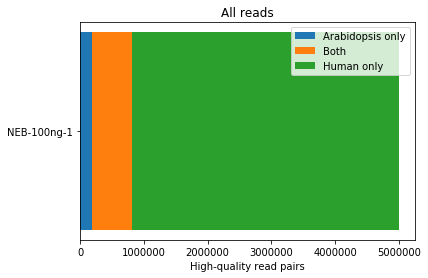

In [74]:
plt.barh([sample], [unique[0]], label="Arabidopsis only")
plt.barh([sample], [both], left=[unique[0]], label="Both")
plt.barh([sample], [unique[1]], left=[unique[0]+both], label="Human only")
plt.xlabel("High-quality read pairs")
plt.title("All reads")
plt.legend()

In [75]:
def rebin(squareHist, factor):
    (nx0, ny0) = squareHist.shape
    return sum(
        squareHist[i::factor, j::factor]
        for i in range(factor)
        for j in range(factor)
    )

## Correlation of mapped lengths for all reads mapping to both genomes

In [76]:
rebin_factor = 8
maxlen = 400
z = rebin(size_corr[:maxlen,:maxlen], rebin_factor)
x = list(range(0, maxlen+0, rebin_factor))
y = list(range(0, maxlen+1, rebin_factor))

Text(0.5, 1.0, 'Reads mapped to both genomes')

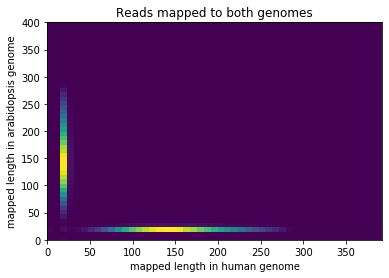

In [77]:
plt.pcolormesh(x, y, z)
plt.xlabel('mapped length in human genome')
plt.ylabel('mapped length in arabidopsis genome')
plt.title('Reads mapped to both genomes')

In [78]:
print("Number of reads with >100 length in both genomes:",
     size_corr[100:,100:].sum() / 2, # Each read is counted twice, so divide by two
     "(",
      size_corr[100:,100:].sum() * 100.0 / size_corr.sum(),
      "%)")

Number of reads with >100 length in both genomes: 627.0 ( 0.09865952080110901 %)


## Study of short fragments in the human genome

Just picking human as one example. Considering all small reads mapping to the human genome, how many are also mapping to arabidopsis genome (with any size).

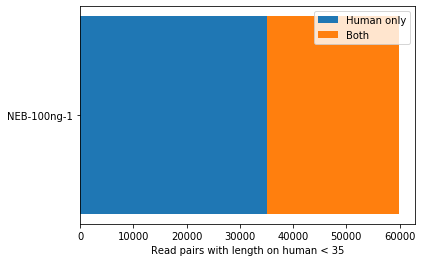

In [80]:
plt.barh([sample], [unique_small[1]], label="Human only")
plt.barh([sample], [mapped_both_and_small[1]], left=[unique_small[1]], label="Both")
plt.xlabel("Read pairs with length on human < {}".format(SMALL_FRAG_THRESH))
plt.legend()

## Conclusion

We saw a sharp peak in the insert size distribution at sizes around 20-35 (very small!). The purpose of this notebook is the investigate if this peak has anything to do with DNA fragments from the other organism. Considering the peak at small inserts in humans, for example, is it caused by fragments from arabidopsis which are not actually so small, but get clipped because they don't actually fit in the human genome.

Almost all of the reads that map to both genomes (in pairs, good quality, etc; `get_read_pairs`) has a short insert size in one genome and a long insert size in the other. These contribute to the peak.

Out of all the small reads mapped to the human genome, a large fraction also maps to the arabidopsis genome, however it is not the majority.